In [68]:
import os
import rdkit
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

In [2]:
import pandas as pd

file_names = [
    'data/mols/mols.txt',
    'data/mols/mols (1).txt',
    'data/mols/mols (2).txt'
]

dfs = []
for file_name in file_names:
    df = pd.read_csv(file_name, header=1, sep='\t')
    for col in df.columns:
        if col == 'smiles': continue
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna()
    df = df.drop_duplicates(subset='smiles')
    dfs.append(df)

In [3]:
MAX_STEP = 4800
for i in range(len(dfs)):
    dfs[i] = dfs[i][dfs[i]['#'] <= MAX_STEP]

In [4]:
for df in dfs:
    df['succ'] = \
        (df['jnk3'] >= 0.5) & \
        (df['qed' ] >= 0.6) & \
        (df['sa'  ] >= .67)
    df['score'] = df['jnk3'] + df['qed'] + df['sa']

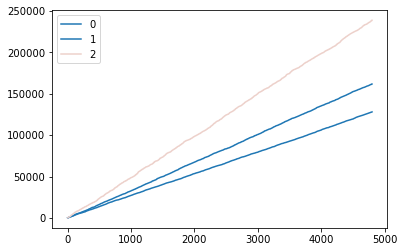

In [71]:
for i, df in enumerate(dfs):
    df = df.groupby('#').sum()
    
    n_succ = 0
    n_succs = []
    for row in df.iterrows():
        n_succ += row[1]['succ']
        n_succs.append(n_succ)
    l = len(n_succs)
    sns.lineplot(
        x=list(range(l)),
        y=n_succs,
        hue=[i] * l
    )
plt.show()

In [5]:
dfs_succ = []
for df in dfs:
    dfs_succ.append(df[df['succ']==True])

In [6]:
from measures import *

ncircs = []
for df in dfs_succ:
    smiles = df['smiles']
    mols = [Chem.MolFromSmiles(smi) for smi in tqdm(smiles)]
    ncirc = NCirc(threshold=0.4)
    ncirc.update(mols)
    print(ncirc.report())
    ncircs.append(ncirc)

100%|██████████| 128099/128099 [00:19<00:00, 6450.35it/s]


1091


100%|██████████| 161739/161739 [00:29<00:00, 5446.81it/s]


1117


100%|██████████| 238871/238871 [00:43<00:00, 5545.17it/s]


3180


In [55]:
def similarity_matrix(mols_A, mols_B):
    fps_A = [fingerprint(mol) for mol in mols_A]
    fps_B = [fingerprint(mol) for mol in mols_B]
    sim_mat = [similarities(fp, fps_B) for fp in tqdm(fps_A)]
    sim_mat = np.array(sim_mat)
    return sim_mat

UNION_TH = 0.4

def circ_union(mols_A, mols_B):
    sim_mat =similarity_matrix(mols_A, mols_B)
    indices_A = np.where(sim_mat.max(axis=1) >= UNION_TH)[0].tolist()
    indices_B = np.where(sim_mat.max(axis=0) >= UNION_TH)[0].tolist()
    AB = [mols_A[i] for i in indices_A] + \
         [mols_B[i] for i in indices_B]
    return AB

def circ_minus(mols_A, mols_B):
    sim_mat =similarity_matrix(mols_A, mols_B)
    indices_A = np.where(sim_mat.max(axis=1) < UNION_TH)[0].tolist()
    indices_B = np.where(sim_mat.max(axis=0) < UNION_TH)[0].tolist()
    Ab = [mols_A[i] for i in indices_A]
    bA = [mols_B[i] for i in indices_B]
    return Ab, bA

In [57]:
ABC = circ_union(circ_union(ncircs[0].circ_mols, ncircs[1].circ_mols), ncircs[2].circ_mols)
aBC = circ_minus(ncircs[0].circ_mols, circ_union(ncircs[1].circ_mols, ncircs[2].circ_mols))[1]
AbC = circ_minus(ncircs[1].circ_mols, circ_union(ncircs[0].circ_mols, ncircs[2].circ_mols))[1]
ABc = circ_minus(ncircs[2].circ_mols, circ_union(ncircs[1].circ_mols, ncircs[0].circ_mols))[1]
Abc = circ_minus(circ_minus(ncircs[0].circ_mols, ncircs[1].circ_mols)[0], ncircs[2].circ_mols)[0]
aBc = circ_minus(circ_minus(ncircs[1].circ_mols, ncircs[0].circ_mols)[0], ncircs[2].circ_mols)[0]
abC = circ_minus(circ_minus(ncircs[2].circ_mols, ncircs[1].circ_mols)[0], ncircs[0].circ_mols)[0]

100%|██████████| 1162/1162 [00:00<00:00, 4291.72it/s]


In [58]:
print(len(ABC), len(aBC), len(AbC), len(ABc), len(Abc), len(aBc), len(abC))

4278 610 806 73 20 25 542


In [60]:
AB = circ_union(ncircs[0].circ_mols, ncircs[2].circ_mols)
Ab, aB = circ_minus(ncircs[0].circ_mols, ncircs[2].circ_mols)
print(len(AB), len(Ab), len(aB))

100%|██████████| 1091/1091 [00:00<00:00, 1701.50it/s]


3214 56 1001


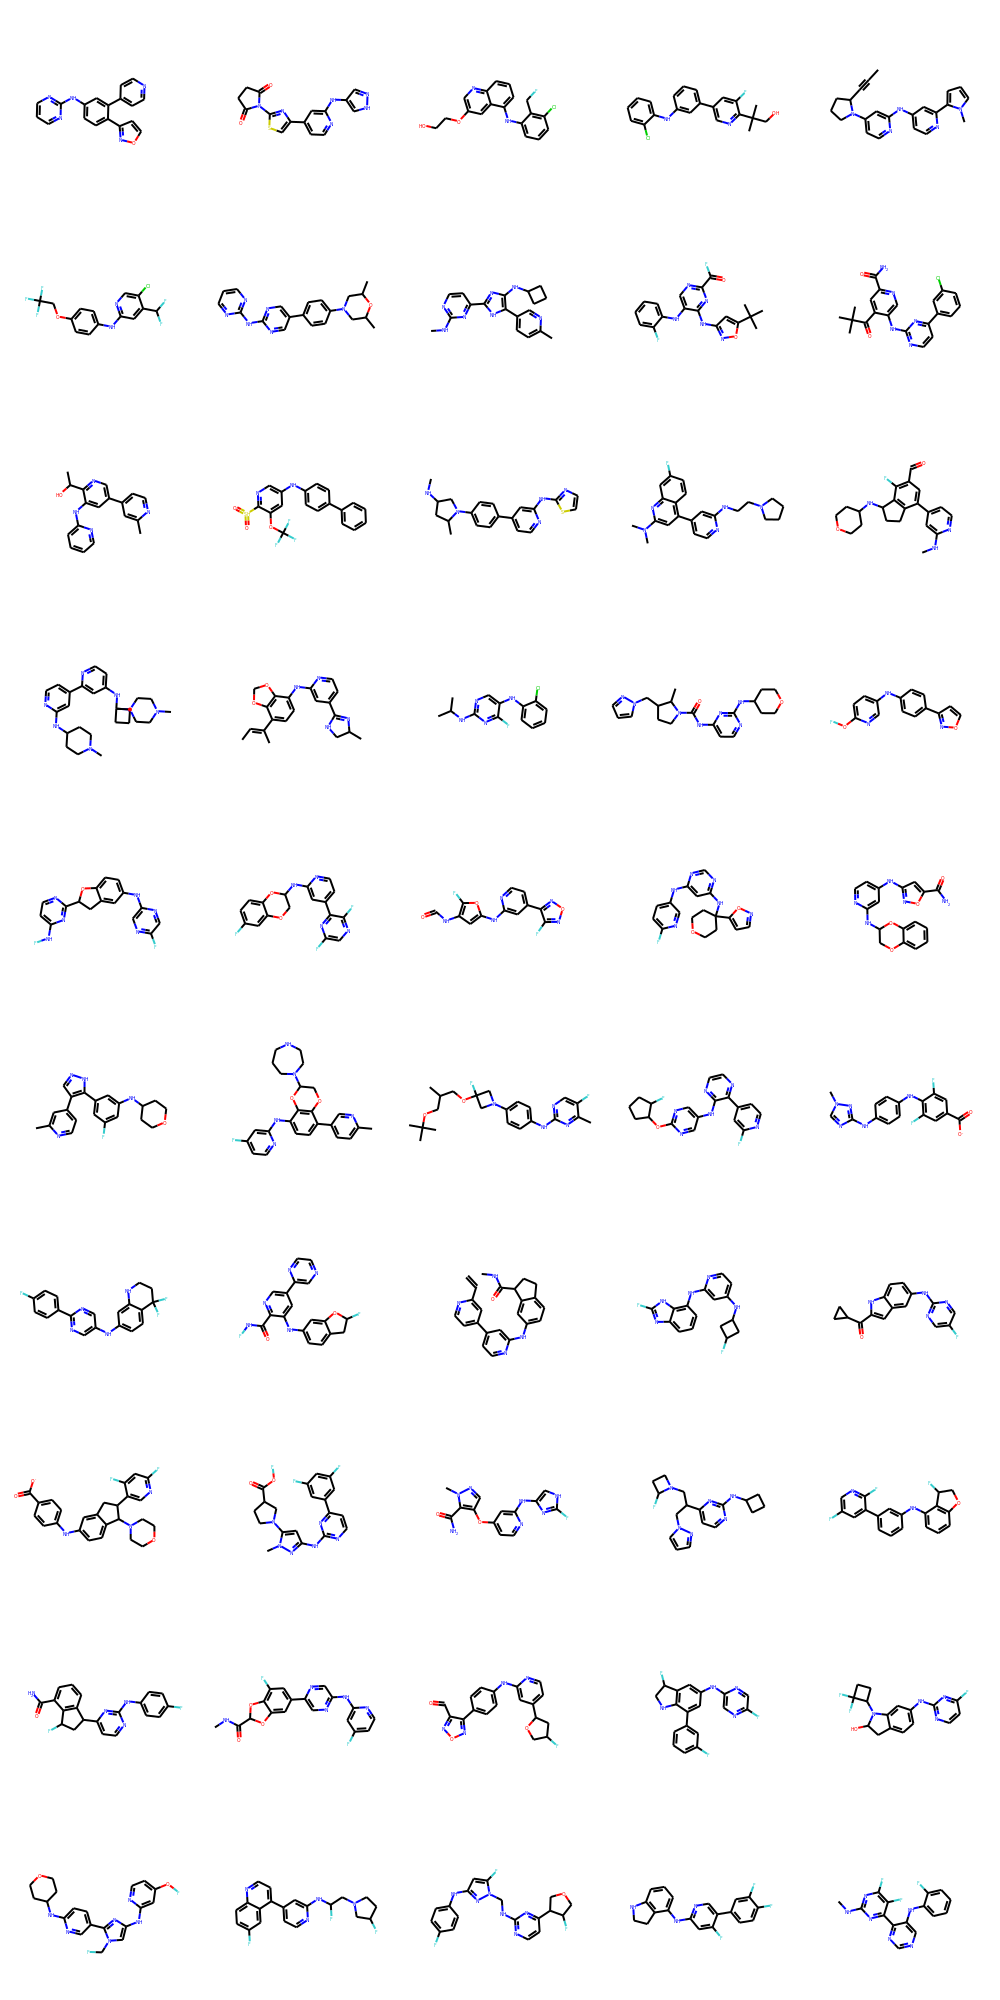

In [46]:
Draw.MolsToGridImage(Ab, molsPerRow=5)

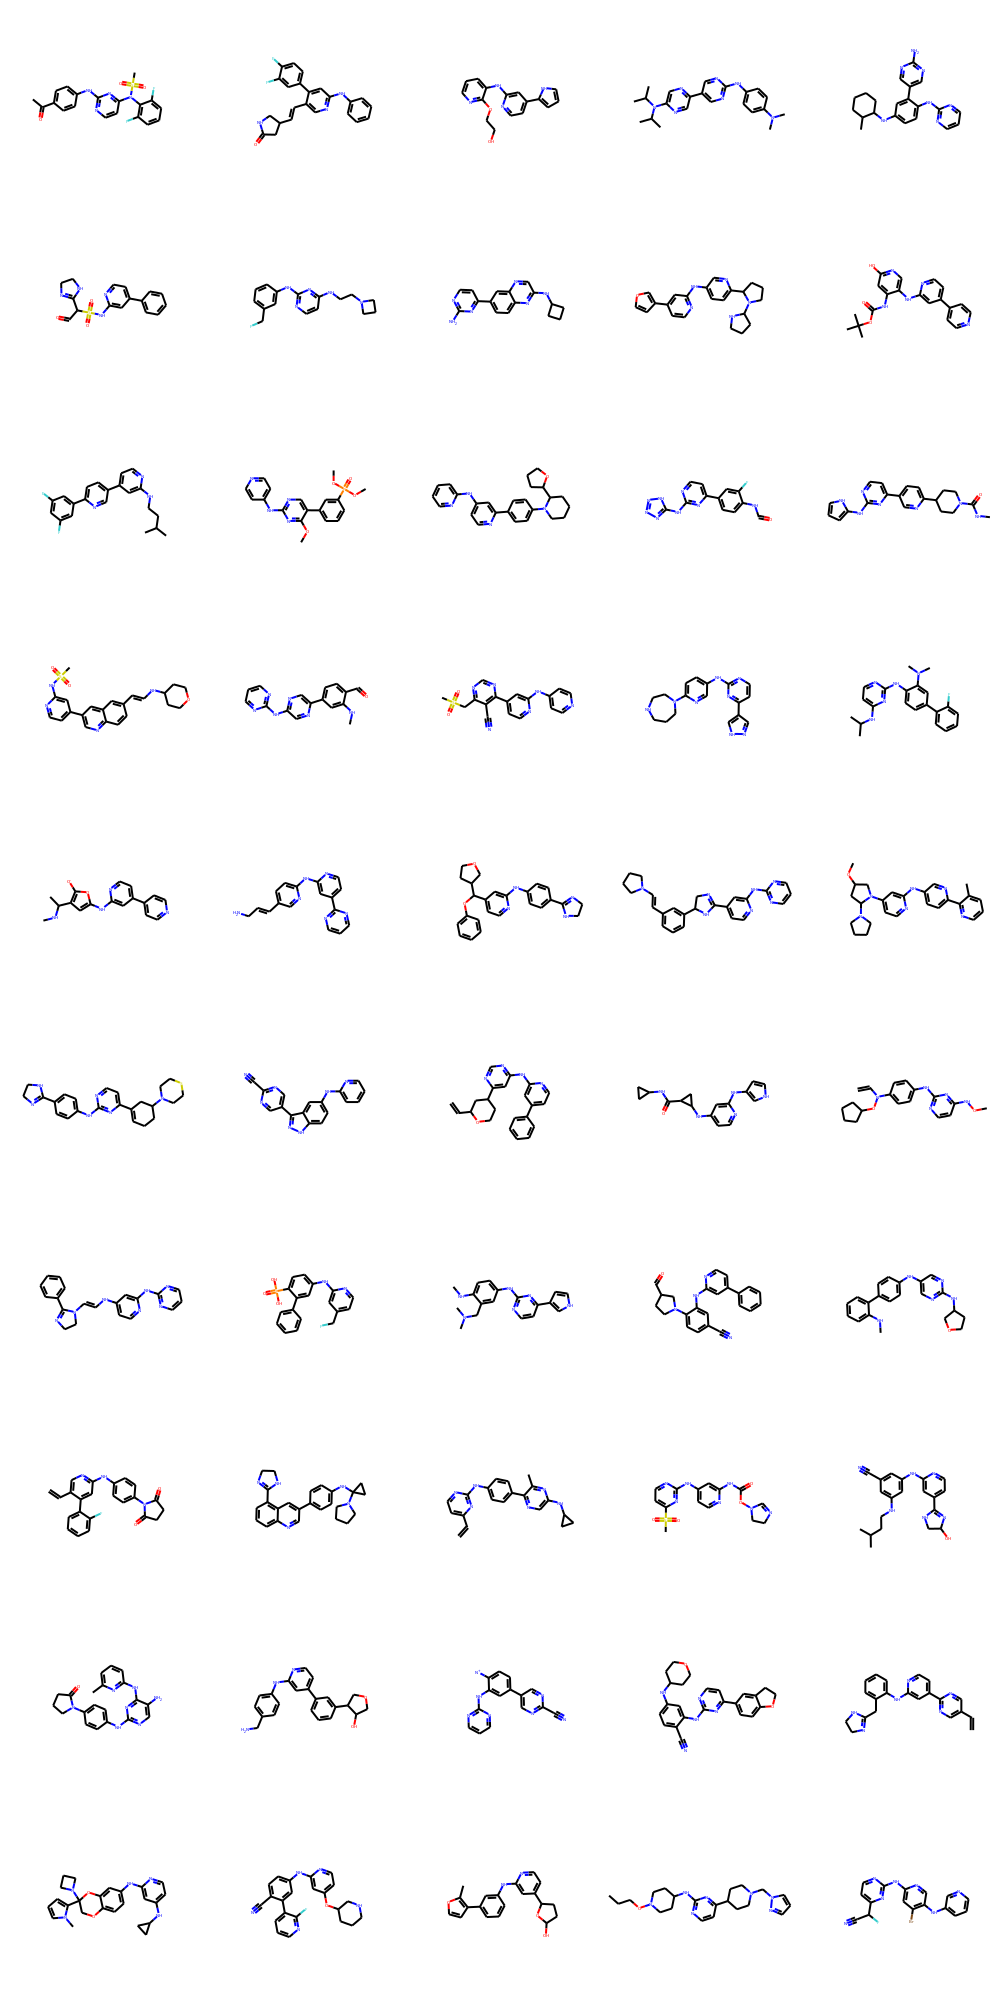

In [47]:
Draw.MolsToGridImage(aB, molsPerRow=5)

In [50]:
dfs_sampled = []
for df in dfs_succ:
    dfs_sampled.append(df.sample(frac=0.01))

In [52]:
smiles = []
for df in dfs_sampled:
    smiles += df['smiles'].tolist()
mols = [Chem.MolFromSmiles(smi) for smi in tqdm(smiles)]
fps  = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in tqdm(mols)]
nfps = np.stack([np.array(fp) for fp in tqdm(fps)])

100%|██████████| 1755/1755 [00:01<00:00, 963.38it/s]


In [58]:
from utils import fingerprint, similarities

sim_mat = np.array([similarities(fp, fps) for fp in tqdm(fps)])

100%|██████████| 1755/1755 [00:00<00:00, 5853.99it/s]


<AxesSubplot:>

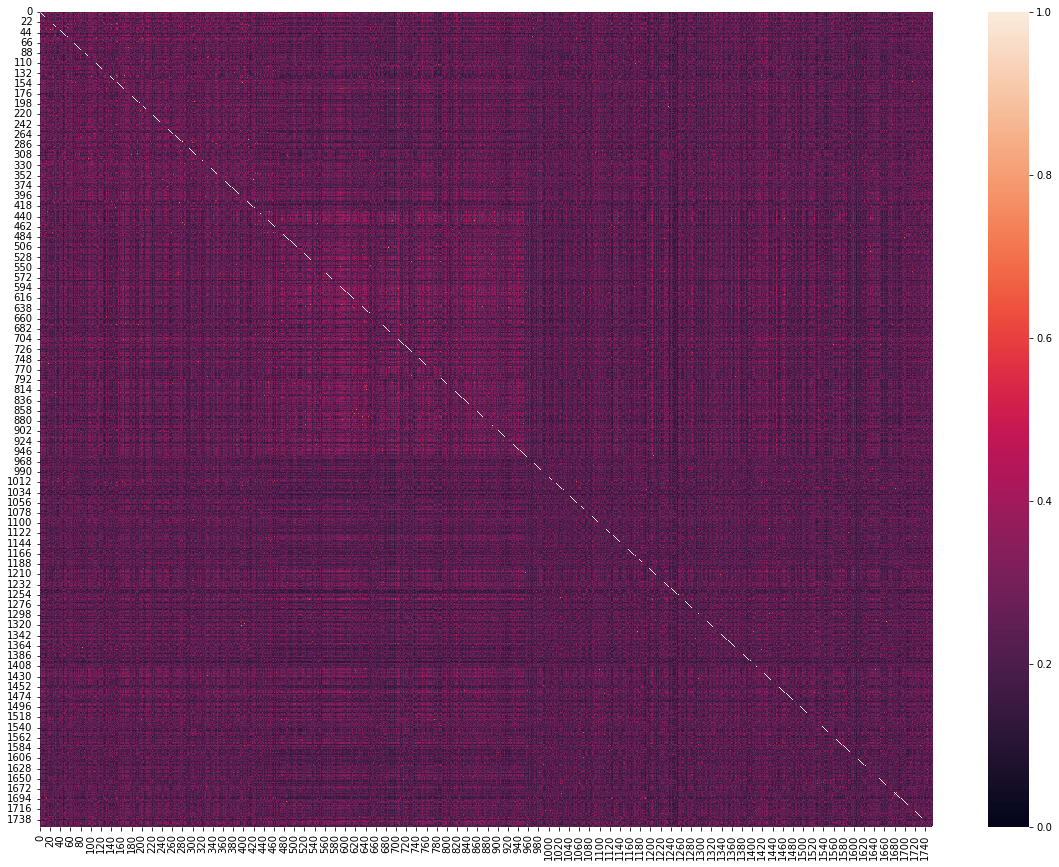

In [75]:
plt.figure(figsize=(20, 15))
sns.heatmap(sim_mat, vmin=0, vmax=1.0)

In [63]:
import umap
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD, PCA, KernelPCA
from sklearn.manifold import MDS

COLORS = ['red', 'blue', 'green']

def visualize(train=None):
#     mapper = umap.UMAP(metric='jaccard', n_neighbors=200, min_dist=0.99)
#     mapper = TruncatedSVD(n_components=2, n_iter=10)
#     mapper = PCA(n_components=2)
#     mapper = KernelPCA(n_components=2, kernel='rbf')
#     if train is None: mapper = mapper.fit(nfps)
#     else:
#         beg = sum([dfs_sampled[j].shape[0] for j in range(train)]) if train > 0 else 0
#         num = dfs_sampled[train].shape[0]
#         mapper = mapper.fit(nfps[beg:beg+num])
#     X = mapper.transform(nfps)

    mapper = MDS(n_components=2, dissimilarity='precomputed')
    X = mapper.fit_transform(1-sim_mat)
    
    labels = []
    for i in range(len(dfs_sampled)):
        labels += [COLORS[i]] * dfs_sampled[i].shape[0]

    plt.figure(figsize=(15, 10))
    plt.scatter(x=X[:,0], y=X[:,1], c=labels, s=1)
    plt.show()

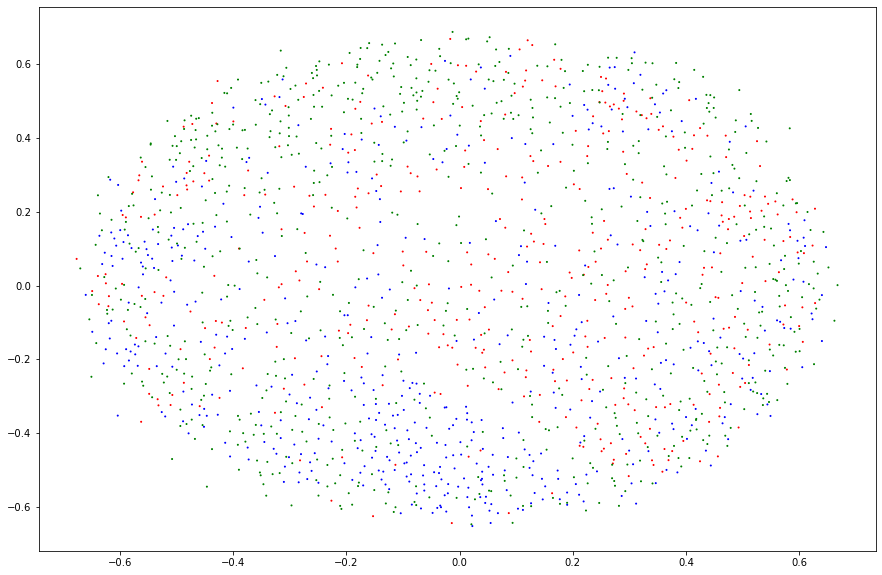

In [64]:
visualize()

In [ ]:
visualize(0)

In [ ]:
visualize(1)

In [ ]:
visualize(2)

In [74]:
import umap
from sklearn.decomposition import TruncatedSVD, PCA, KernelPCA
from sklearn.manifold import MDS

COLORS = ['red', 'blue', 'green']

In [75]:
fps = []
for ncirc in ncircs:
    fps += ncirc.circ_fps
nfps = np.stack([np.array(fp) for fp in tqdm(fps)])
mapper = umap.UMAP(metric='jaccard', n_neighbors=200, min_dist=0.99)
mapper = mapper.fit(nfps)
X = mapper.transform(nfps)

100%|██████████| 5388/5388 [00:05<00:00, 957.96it/s] 
/home/yutxie/miniconda3/envs/em/lib/python3.8/site-packages/umap/umap_.py:1760: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


In [76]:
labels = []
for i in range(len(circles)):
    labels += [COLORS[i]] * len(circles[i])

plt.figure(figsize=(15, 10))
# plt.scatter(x=X[:,0], y=X[:,1], c=labels, s=200, alpha=0.5)
plt.scatter(x=X[::-1,0], y=X[::-1,1], c=labels[::-1], s=200, alpha=0.5)
plt.show()

NameError: name 'circles' is not defined


100%|██████████| 1091/1091 [00:00<00:00, 2114.36it/s][A
